In [22]:
DATAPATH = os.path.join(os.getcwd(), "data")
os.environ['DATAPATH'] = DATAPATH
CORTEX_TO_ABBREVIATION = {
    'Primary_Visual': 'PV',
    'MT+_Complex_and_Neighboring_Visual_Areas': 'MT+CNVS',
    'Dorsal_Stream_Visual': 'DSV',
    'Early_Visual': 'EV',
    'Ventral_Stream_Visual': 'VSV',
    'Somatosensory_and_Motor': 'SM',
    'Premotor': 'Pre',
    'Posterior_Cingulate': 'PC',
    'Early_Auditory': 'EA',
    'Temporo-Parieto-Occipital_Junction': 'TPOJ',
    'Dorsolateral_Prefrontal': 'DP',
    'Superior_Parietal': 'SP',
    'Paracentral_Lobular_and_Mid_Cingulate': 'PLMC',
    'Anterior_Cingulate_and_Medial_Prefrontal': 'ACMP',
    'Orbital_and_Polar_Frontal': 'OPF',
    'Inferior_Frontal': 'IF',
    'Posterior_Opercular': 'PO',
    'Insular_and_Frontal_Opercular': 'IFO',
    'Auditory_Association': 'AA',
    'Inferior_Parietal': 'IP',
    'Medial_Temporal': 'MT',
    'Lateral_Temporal': 'LT'
}
COLORS = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', 
            '#00ffff', '#800000', '#008000', '#000080', '#808000', 
            '#800080', '#008080', '#ff8080', '#80ff80', '#8080ff', 
            '#ffff80', '#ff80ff', '#80ffff', '#c00000', '#00c000', 
            '#0000c0', '#c0c000', '#c000c0']
NUM_ROIS = 360


In [23]:
def get_hcp_atlas_df():
    datapath = os.environ['DATAPATH']
    atlas_path = os.path.join(os.path.join(datapath, "cam_can_avg_new"), "HCP-MMP1_UniqueRegionList.csv")
    hcp_atlas_df = pd.read_csv(atlas_path)
    cortices = hcp_atlas_df['cortex']
    region_indices_to_cortices = {index : cortex for index, cortex in enumerate(cortices)}
    color_index = -1
    seen_cortices = set()
    region_indices_to_colors = {}

    for index in region_indices_to_cortices:
        cortex = region_indices_to_cortices[index]
        if cortex not in seen_cortices:
            color_index += 1
            region_indices_to_colors[index] = COLORS[color_index]
            seen_cortices.add(region_indices_to_cortices[index])    
        else:
            region_indices_to_colors[index] = COLORS[color_index]
        
    return hcp_atlas_df
def get_cortices_and_cortex_ids_to_cortices():
    hcp_atlas_df = get_hcp_atlas_df()
    cortices = hcp_atlas_df['cortex']
    cortex_ids = hcp_atlas_df['Cortex_ID']
    cortex_ids_to_cortices = {cortex_ids[i] : cortices[i] for i in range(NUM_ROIS)}
    
    return cortices, cortex_ids_to_cortices


In [24]:
def get_embeddings_df(hyperboloid_embeddings):
    """
    Projects Hyperboloid embeddings into Poincare Embeddings
    Returns: 
    embeddings_df with columns 
        x : x coordinate in Poincare Disk :float, 
        y : y coordinate in Poincare Disk :float, 
        label : cortex id number :int [1 - 22], 
        id : ROI id number :int [0 - 359],
        LR : left or right hemisphere embedding symbolized by 'L' or 'R' :str
    """
    hcp_atlas_df = get_hcp_atlas_df()
    
    region_indices_to_cortex_ids = {i : hcp_atlas_df['Cortex_ID'][i] for i in range(NUM_ROIS)}
    c = 1.
    torch_embeddings = torch.from_numpy(hyperboloid_embeddings)
    poincare_embeddings = [to_poincare(torch_embedding, c) for torch_embedding in torch_embeddings]
    embeddings_df = pd.DataFrame({'x': [poincare_embeddings[i][0] for i in range(NUM_ROIS)], 
                                        'y': [poincare_embeddings[i][1] for i in range(NUM_ROIS)],
                                        'label': [region_indices_to_cortex_ids[i] for i in range(NUM_ROIS)],
                                        'id': [i for i in range(NUM_ROIS)],
                                        'LR': hcp_atlas_df['LR']}
                                )
    return embeddings_df   

def to_poincare(x, c):
    K = 1. / c
    sqrtK = K ** 0.5
    d = x.size(-1) - 1
#     return sqrtK * x.narrow(-1, 1, d) / (x[:, 0:1] + sqrtK)
    return sqrtK * x.narrow(-1, 1, d) / (x[0] + sqrtK)

def scale_embeddings_df_to_poincare_disk(embeddings_df):
    eps = 1e-2
    embeddings_df['r'] = torch.sqrt(torch.Tensor(embeddings_df['x']) ** 2 + torch.Tensor(embeddings_df['y']) ** 2)
    max_radius = np.max(embeddings_df.r)
    embeddings_df['x'] /= (max_radius + eps)
    embeddings_df['y'] /= (max_radius + eps)
    embeddings_df['r'] /= (max_radius + eps)
    return embeddings_df


In [25]:
def plot_subnetwork_embeddings(subnet_abbreviation, embeddings, title=None, use_scale=False, square_borders=False, use_centroids=False, use_legend=False):
    if subnet_abbreviation not in CORTEX_TO_ABBREVIATION.values():
        raise AssertionError("Invalid subnet_abbreviation : {}".format(subnet_abbreviation))
    
    # Create a list of labels for the legend
    cortices, cortex_ids_to_cortices = get_cortices_and_cortex_ids_to_cortices()

    labels = list(set(cortices))
    embeddings_df = get_embeddings_df(embeddings) 
    # Create the legend
    if use_scale: embeddings_df = scale_embeddings_df_to_poincare_disk(embeddings_df)
    
    # Make all embeddings that are not part of the subnetwork very transparent i.e. having a low alpha value
    for i in embeddings_df.label.unique():
        if CORTEX_TO_ABBREVIATION[cortex_ids_to_cortices[i]] == subnet_abbreviation:
            emb_L = embeddings_df.loc[(embeddings_df.LR == "L")]
            plt.scatter(emb_L.loc[(emb_L.label == i), 'x'], 
                        emb_L.loc[(emb_L.label == i), 'y'], 
                        c = COLORS[i],
                        s = 50, 
                        marker = "v",)
                        # label = cortex_ids_to_cortices[i]) avoid repeating same labels but with differnet shape
            emb_R = embeddings_df.loc[(embeddings_df.LR == "R")]
            plt.scatter(emb_R.loc[(emb_R.label == i), 'x'], 
                        emb_R.loc[(emb_R.label == i), 'y'], 
                        c = COLORS[i], 
                        s = 50,
                        marker = "s",
                        label = CORTEX_TO_ABBREVIATION[cortex_ids_to_cortices[i]])
        else:
            emb_L = embeddings_df.loc[(embeddings_df.LR == "L")]
            plt.scatter(emb_L.loc[(emb_L.label == i), 'x'], 
                        emb_L.loc[(emb_L.label == i), 'y'], 
                        c = COLORS[i],
                        s = 50, 
                        marker = "v",
                        alpha = 0.15)
                        # label = cortex_ids_to_cortices[i]) avoid repeating same labels but with differnet shape
            emb_R = embeddings_df.loc[(embeddings_df.LR == "R")]
            plt.scatter(emb_R.loc[(emb_R.label == i), 'x'], 
                        emb_R.loc[(emb_R.label == i), 'y'], 
                        c = COLORS[i], 
                        s = 50,
                        marker = "s",
                        alpha = 0.05,
                        label = CORTEX_TO_ABBREVIATION[cortex_ids_to_cortices[i]])
            
        # Plot a dotted circle around the subnetwork embeddings with radius equal to the average radius of all the embeddings in the subnetwork
        if CORTEX_TO_ABBREVIATION[cortex_ids_to_cortices[i]] == subnet_abbreviation:
            embeddings_from_id = embeddings_df[embeddings_df.label == i][['x', 'y']].values
            avg_radius = 0
            origin = (0, 0)  # Define the origin
            for embedding_coords in embeddings_from_id:
                # hyperbolic_radius = poincare_dist(embedding_coords, origin)
                hyperbolic_radius = np.linalg.norm(embedding_coords)
                print("HYPER RADIUS", hyperbolic_radius)
                avg_radius += hyperbolic_radius
            avg_radius /= len(embeddings_from_id)
            print("LEN EMBEDDINGS FROM ID", len(embeddings_from_id))
            print("AVERAGE RADIUS", avg_radius)
            circ = plt.Circle((0, 0), 
                        radius=avg_radius, 
                        edgecolor=COLORS[i], 
                        facecolor='None', 
                        linewidth=3, 
                        alpha=0.75,
                        linestyle='dotted')
            ax = plt.gca()
            ax.add_patch(circ)
    # Shrink current axis by 20%
    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    if use_legend:
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fancybox=True, shadow=True, title='Subnetworks', borderaxespad=0.)
    circ = plt.Circle((0, 0), 
                    radius=1, 
                    edgecolor='black', 
                    facecolor='None', 
                    linewidth=3, 
                    alpha=0.5)
    ax.add_patch(circ)
    
    if title != None:
        plt.title(title, size=16)
    plt.savefig("fhnn_embedding_for_average_592_plv.png")
    ax.set_xticks([])
    ax.set_yticks([])
    if not square_borders: ax.set_axis_off()
    permuted_colors = [COLORS[i] for i in embeddings_df.label.unique()]


HYPER RADIUS tensor(0.5418)
HYPER RADIUS tensor(0.5201)
HYPER RADIUS tensor(0.5393)
HYPER RADIUS tensor(0.7130)
HYPER RADIUS tensor(0.1513)
HYPER RADIUS tensor(0.1870)
LEN EMBEDDINGS FROM ID 6
AVERAGE RADIUS tensor(0.4421)
HYPER RADIUS tensor(0.8368)
HYPER RADIUS tensor(0.8066)
HYPER RADIUS tensor(0.6839)
HYPER RADIUS tensor(0.7973)
HYPER RADIUS tensor(0.8162)
HYPER RADIUS tensor(0.8273)
HYPER RADIUS tensor(0.7010)
HYPER RADIUS tensor(0.8003)
HYPER RADIUS tensor(0.6065)
HYPER RADIUS tensor(0.6809)
HYPER RADIUS tensor(0.4519)
HYPER RADIUS tensor(0.7535)
HYPER RADIUS tensor(0.6765)
HYPER RADIUS tensor(0.7535)
LEN EMBEDDINGS FROM ID 14
AVERAGE RADIUS tensor(0.7280)
HYPER RADIUS tensor(0.4878)
HYPER RADIUS tensor(0.4485)
HYPER RADIUS tensor(0.3451)
HYPER RADIUS tensor(0.7907)
HYPER RADIUS tensor(0.4737)
HYPER RADIUS tensor(0.9263)
LEN EMBEDDINGS FROM ID 6
AVERAGE RADIUS tensor(0.5787)
HYPER RADIUS tensor(0.8534)
HYPER RADIUS tensor(0.8697)
HYPER RADIUS tensor(0.8218)
HYPER RADIUS tensor(0.

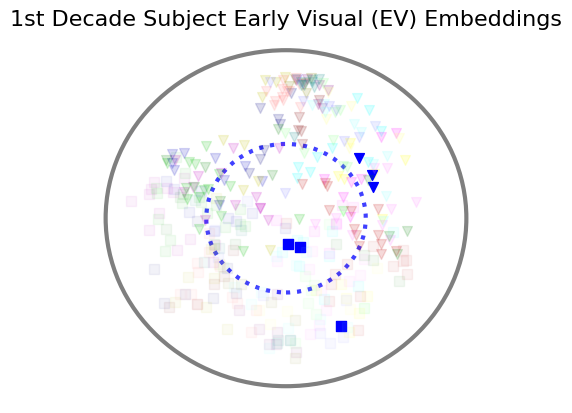

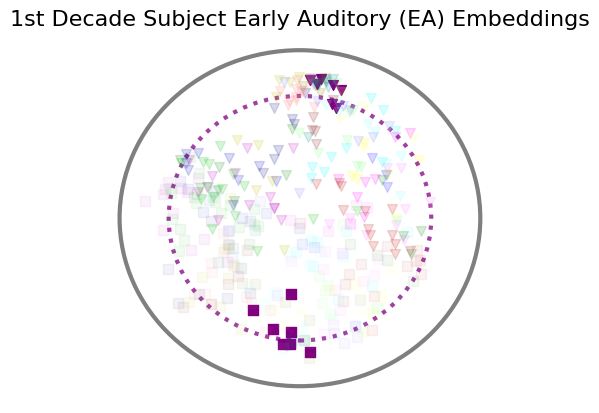

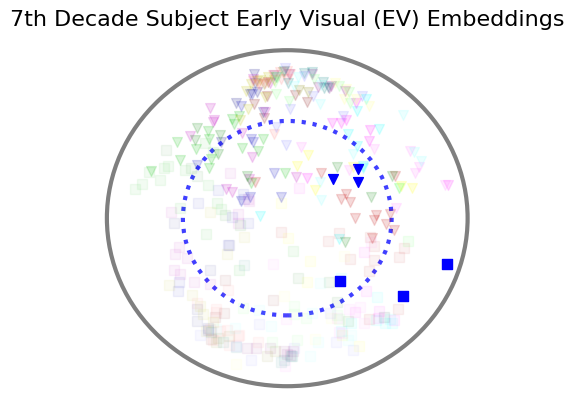

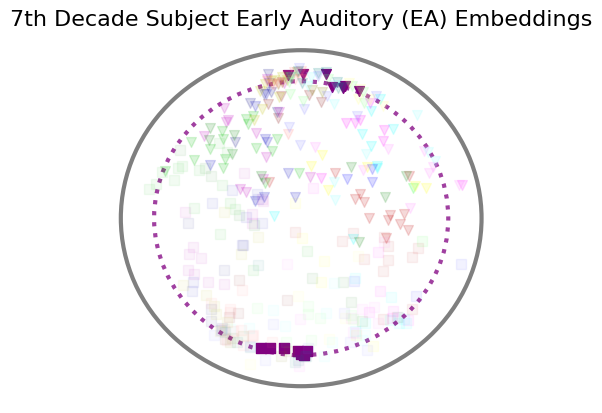

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
run_num = "2"
embeddings_dir = os.path.join("logs", "lp", "2024_6_12", run_num, "embeddings")

for subject_index in [0, 586]:
    for subnet_abbrev in  ["EV", "EA"]:
        try:
            embeddings_path = os.path.join(embeddings_dir, f"embeddings_train_{subject_index}.npy")
            embeddings = np.load(embeddings_path)
        except:
            try:
                embeddings_path = os.path.join(embeddings_dir,  f"embeddings_test_{subject_index}.npy")
                embeddings = np.load(embeddings_path)
            except:
                embeddings_path = os.path.join(embeddings_dir,  f"embeddings_val_{subject_index}.npy")
                embeddings = np.load(embeddings_path)
        
        plt.figure()
        subnet_str = ""
        if subnet_abbrev == "EV": subnet_str = "Early Visual"
        if subnet_abbrev == "EA": subnet_str = "Early Auditory"
        subject_str = "1st Decade Subject" if subject_index == 0 else "7th Decade Subject"
        plot_subnetwork_embeddings(subnet_abbrev, embeddings, f"{subject_str} {subnet_str} ({subnet_abbrev}) Embeddings")